In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sexpy
import astropy.coordinates as coord
from astropy import units as u
from toolbox.astro import angsep
import ashd
from astropy.io import fits
import pyds9
from astropy.table import Table
from astropy.coordinates import SkyCoord
outdir = '/Users/protostar/local_data/asas-sn-hugs-io/sex/out'
plt.style.use('jpg')
pixscale = 7.8 # arcsec/pix

In [2]:
cat = sexpy.read_cat(os.path.join(outdir, 'Cetus-sex.cat'))
mask = cat['FLUX_RADIUS']>0
cat = cat[mask]
cat['r_arcmin'] = cat['FLUX_RADIUS']*pixscale/60
ra, dec = 6.5486882, -11.043124
cand_i = angsep(ra, dec, cat['ALPHA_J2000'], cat['DELTA_J2000']).argmin()
cat['fwhm_arcmin'] = cat['FWHM_IMAGE']*pixscale/60
size_cut = cat['r_arcmin']>1.5

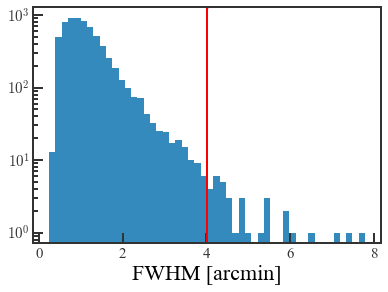

In [3]:
plt.hist(cat['fwhm_arcmin'], bins=50, log=True)
plt.axvline(cat['fwhm_arcmin'][cand_i], c='r', lw=2)
plt.xlabel('FWHM [arcmin]');

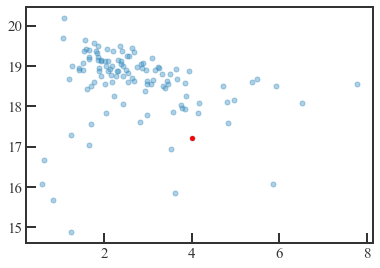

In [4]:
plt.scatter(cat['fwhm_arcmin'][size_cut], cat['MAG_APER_2'][size_cut], alpha=0.4)
plt.plot(cat['fwhm_arcmin'][cand_i], cat['MAG_APER_2'][cand_i], 'ro');

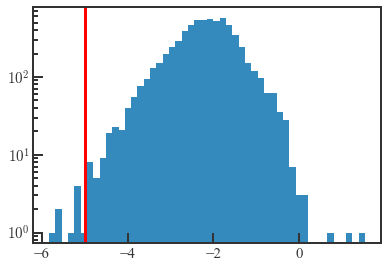

In [5]:
diff = cat['MAG_AUTO'] - cat['MAG_APER_1']
plt.hist(diff, bins=50, log=True)
plt.axvline(diff[cand_i], c='r', lw=3);

In [6]:
dwarfs = Table.read('/Users/protostar/Downloads/nearby-dwarfs.fits')
dwarfs.rename_column('_RAJ2000', 'ra')
dwarfs.rename_column('_DEJ2000', 'dec')
dwarfs = dwarfs[(~np.isnan(dwarfs['muV'])) & (~np.isnan(dwarfs['R1']))]

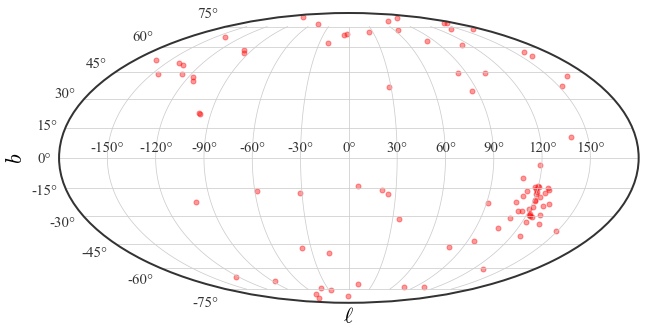

In [7]:
fig = plt.figure(figsize=(10,7))
ra_dwarfs = coord.Angle(dwarfs['ra'])
#ra_dwarfs = ra_dwarfs.wrap_at(180*u.degree)
dec_dwarfs = coord.Angle(dwarfs['dec'])
skycoords = SkyCoord(ra_dwarfs, dec_dwarfs)
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(skycoords.galactic.l.wrap_at(180*u.deg).radian, 
           skycoords.galactic.b.wrap_at(180*u.deg).radian, 
           c='r', alpha=0.4, marker='o')
ax.set_xlabel('$\ell$')
ax.set_ylabel('$b$');

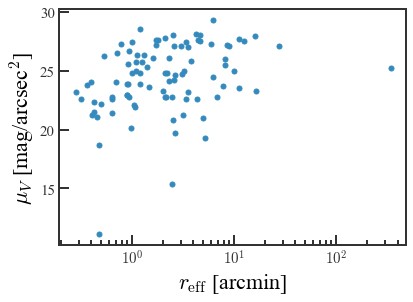

In [8]:
plt.scatter(dwarfs['R1'], dwarfs['muV'])
plt.xscale('log')
plt.xlabel('$r_\mathrm{eff}$ [arcmin]')
plt.ylabel('$\mu_V$ [mag/arcsec$^2$]');

In [9]:
mask = (dwarfs['R1']<10) & (dwarfs['R1']>2) & (dwarfs['muV']<26.4) & (dwarfs['muV']>23)
coords = dwarfs['ra', 'dec']
dwarfs[mask]['ra', 'dec', 'Name', 'MType', 'D', 'muV', 'R1']

ra,dec,Name,MType,D,muV,R1
deg,deg,,,kpc,mag / arcsec2,arcmin
float64,float64,str29,str9,int16,float32,float32
162.3375,51.05,Willman 1,dSph,38,26.1,2.3
227.285416667,67.2225,Ursa Minor,dSph,76,26.0,8.2
100.402916667,-50.9661111111,Carina,dSph,105,25.5,8.2
168.37,22.1516666667,Leo II,dSph,233,24.2,2.6
11.4158333333,38.0411111111,Andromeda I,dSph,745,24.7,3.1
8.89083333333,36.4977777778,Andromeda III,dSph,748,24.8,2.2
19.1241666667,33.4191666667,Andromeda II,dSph,652,24.5,6.2
351.632083333,50.6758333333,Andromeda VII,dSph,762,23.2,3.5


In [10]:
ds9 = pyds9.DS9()
butler = ashd.Butler()

In [11]:
name = 'Cetus'
fetch = dwarfs['Name']==name
ra, dec = coords[fetch]['ra', 'dec'][0]
fn = butler.get_image_fn(ra, dec)
ds9.set('file '+fn)
ds9.set('regions', 'icrs; circle({},{},15") # color=red '.format(ra, dec))
reg_fn = os.path.join(outdir, name.replace(' ', '-')+'-sex.reg')
ds9.set('regions load '+reg_fn);

## Visible in ASAS-SN
1. Leo II   $\star\star\star$
2. Andromeda III
3. Andromeda II
4. IC 10
5. LGS 3 (Local Group Suspect 3)
6. Phoenix $\star\star\star$
7. Cetus $\star\star\star$
8. WLM (Wolf-Lundmark-Melotte)
9. IC 3104

In [12]:
cutout = ashd.cutout(butler.get_data(ra, dec), (ra, dec), butler.get_header(ra, dec))
hdulist = fits.HDUList([fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header(relax=False))])
ds9.set_pyfits(hdulist)
ds9.set('regions', 'fk5; circle({},{},15") # color=red '.format(ra, dec))

1